## Twitter Sentiment Analysis

### Import packages

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Read training file

In [2]:
df = pd.read_csv("train_E6oV3lV.csv")
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


#### Check the count for each of the target variable class

In [3]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

#### Remove 'id' column from the training dataframe as it is not required

In [4]:
df.drop('id', axis=1, inplace=True)

#### Initial EDA

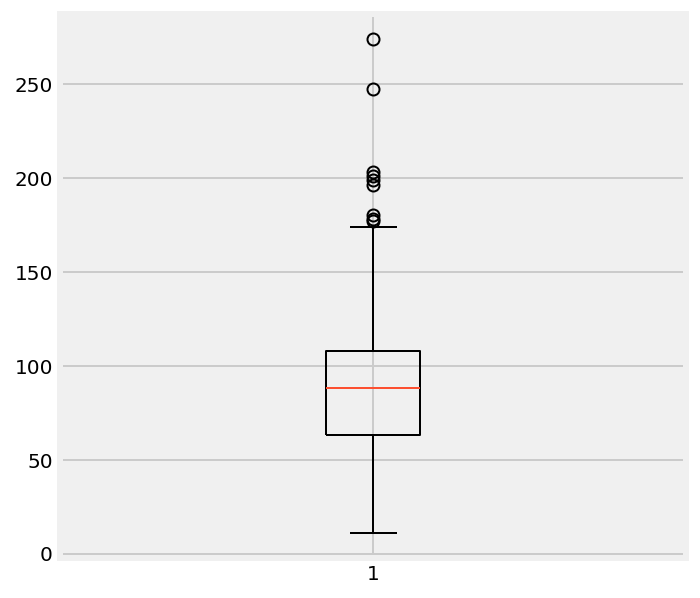

In [6]:
## Calculate the length of each tweet
df['pre_clean_len'] = [len(t) for t in df.tweet]

## Create box-plot to check outliers in the dataset
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

#### The length of tweet in Twitter was 140 charaters (when this dataset was extracted) and there exists a lot of tweets with length greater than the limit

In [7]:
## Checking few tweets where length is greater than 140
df[df.pre_clean_len > 140].head(10)

,label,tweet,pre_clean_len
7,0,the next school year is the year for exams.ð...,143
335,0,watching the @user leadership embrace &amp; ki...,146
433,0,@user * sweets ð°ð©ð¬ð­ð«â¨!!!!!! ...,145
474,0,this is a shockingly and increasingly #viole...,141
565,0,thank youðsoo muchð pretty @user i feel ...,142
620,0,@user back to @user after a v traumatic few m...,141
773,0,ðð»#pretending#to#be #when #you're#in#pai...,151
774,0,@user @user @user @user @user evening my de...,147
1100,0,2nite was sad bc i ordered fries @ denny's &am...,141
1142,0,sick verbal irony of the #left: equaling homo...,144


#### The html encoding has not been converted into text which has increased the characters in the tweet

### Text Cleaning

#### A function to clean each tweet

In [8]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

## Tokenizer
tok = WordPunctTokenizer()

## Regex pattern to remove @mentions from tweet
pat1 = r'@[A-Za-z0-9_]+'

## Regex pattern to remove websites
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))

## Regex pattern to remove websites without https 
www_pat = r'www.[^ ]+'

## Negative words if not handled remove the text after ', e.g: isn't will become isn post cleaning
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    ## Convert HTML encoding to text using BeautifulSoup
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

#### Clean tweets in the training set

In [9]:
%%time
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%5000 == 0):
        print("Tweets %d of %d have been processed" % ( i+1, len(df) ))
    clean_tweet_texts.append(tweet_cleaner_updated(df['tweet'][i]))

Tweets 5000 of 31962 have been processed
Tweets 10000 of 31962 have been processed
Tweets 15000 of 31962 have been processed
Tweets 20000 of 31962 have been processed
Tweets 25000 of 31962 have been processed
Tweets 30000 of 31962 have been processed
CPU times: user 9.86 s, sys: 100 ms, total: 9.96 s
Wall time: 9.98 s


#### Create dataframe with label and cleaned tweet

In [10]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
clean_df['target'] = df.label

#### Grouping tweets by label and then resetting index to create two distinct groups

In [12]:
clean_df = clean_df.sort_values(by='target').reset_index()
clean_df.head()

,index,tweet,target
0,0,when father is dysfunctional and is so selfish...,0
1,20906,families and countless friends must bury these...,0
2,20905,as long as your both after all that what life ...,0
3,20904,foxnewssunday your panel of anti trump pundits...,0
4,20903,hillary clinton donald trump going at it like ...,0


In [13]:
## Removing index column from the dataframe as it is not required
clean_df.drop('index', axis=1, inplace=True)

In [14]:
clean_df[clean_df.target==0].tail()

,tweet,target
29715,so exo dropped music videos today and have not...,0
29716,made my first purchase from istore yday and wa...,0
29717,might be discharge tgn sunct hospital hospital...,0
29718,now playing masaji watanabe in the garden afte...,0
29719,eat well feel swell health wealth love happine...,0


#### Hate tweets start from 29720 index 

#### Create wordclouds for hate tweets and normal tweets to check frequently ised words in both the classes

In [15]:
hate_tweets = clean_df[clean_df.target == 1]
hate_string = []
for t in hate_tweets.tweet:
    hate_string.append(t)
hate_string = pd.Series(hate_string).str.cat(sep=' ')

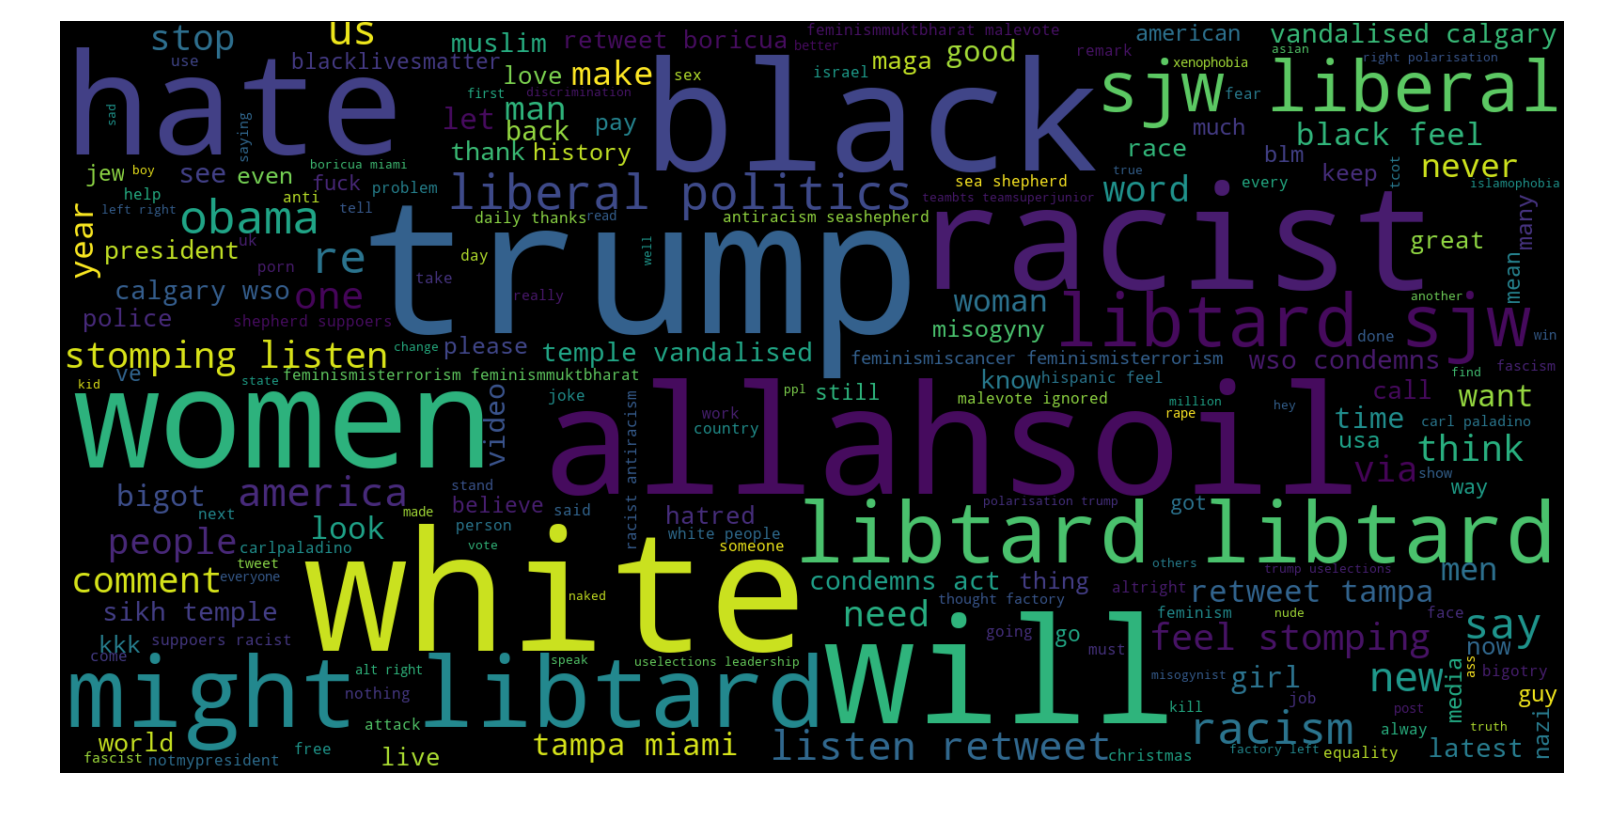

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(hate_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
pos_tweets = clean_df[clean_df.target == 0]
pos_string = []
for t in pos_tweets.tweet:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

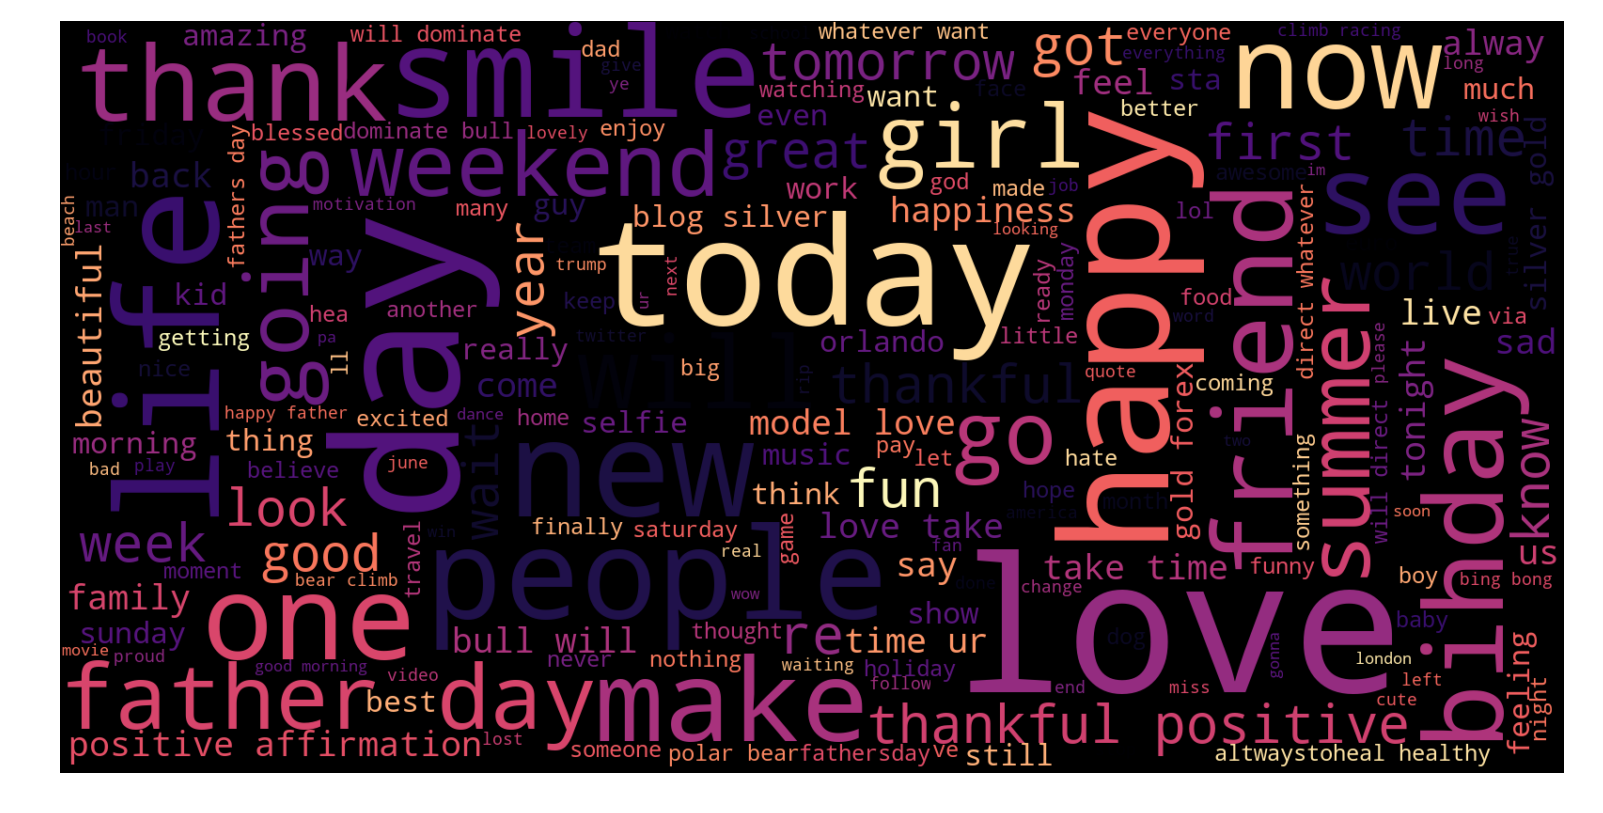

In [18]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Create count vectorizer using clean text

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(clean_df.tweet)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [20]:
len(cvec.get_feature_names())

37524

#### Next, create term frequency matrix

In [21]:
neg_doc_matrix = cvec.transform(clean_df[clean_df.target == 1].tweet)
pos_doc_matrix = cvec.transform(clean_df[clean_df.target == 0].tweet)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [22]:
document_matrix = cvec.transform(clean_df.tweet)

#### For each of the class, calculate term frequency separately

In [23]:
%%time
pos_batches = np.linspace(0,29719,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(pos_batches)-2):
        print (pos_batches[i+1],"entries' term frequency calculated")
    i += 1

300 entries' term frequency calculated
3302 entries' term frequency calculated
6304 entries' term frequency calculated
9305 entries' term frequency calculated
12307 entries' term frequency calculated
15309 entries' term frequency calculated
18311 entries' term frequency calculated
21313 entries' term frequency calculated
24315 entries' term frequency calculated
27317 entries' term frequency calculated
29719 entries' term frequency calculated
CPU times: user 1.1 s, sys: 1 s, total: 2.1 s
Wall time: 2.1 s


In [24]:
%%time
hate_batches = np.linspace(29720,31962,100).astype(int)
i=0
neg_tf = []
while i < len(hate_batches)-1:
    batch_result = np.sum(document_matrix[hate_batches[i]:hate_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(hate_batches)-2):
        print (hate_batches[i+1],"entries' term freuquency calculated")
    i += 1

29742 entries' term freuquency calculated
29969 entries' term freuquency calculated
30195 entries' term freuquency calculated
30422 entries' term freuquency calculated
30648 entries' term freuquency calculated
30874 entries' term freuquency calculated
31101 entries' term freuquency calculated
31327 entries' term freuquency calculated
31554 entries' term freuquency calculated
31780 entries' term freuquency calculated
31962 entries' term freuquency calculated
CPU times: user 224 ms, sys: 16 ms, total: 240 ms
Wall time: 247 ms


#### Create term frequency dataframe by combining both normal and hate term frequency

In [25]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

,0,1
aa,0,2
aaa,0,4
aaaaa,0,1
aaaaaand,0,1
aaaaah,0,1


#### Add a new column with total values

In [26]:
term_freq_df.columns = ['normal', 'hate']
term_freq_df['total'] = term_freq_df['normal'] + term_freq_df['hate']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,normal,hate,total
the,843,9396,10239
to,568,9300,9868
you,500,5452,5952
and,368,4579,4947
in,452,4253,4705
for,250,4262,4512
is,462,3846,4308
of,461,3801,4262
my,73,3645,3718
it,204,3441,3645


### Data Modeling

In [27]:
x = clean_df.tweet
y = clean_df.target

In [28]:
from sklearn.cross_validation import train_test_split
SEED = 2540
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

/home/purveshkatkoria/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Check test-train split

In [29]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 1]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 0]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 1]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 0]) / (len(x_test)*1.))*100))

Train set has total 31322 entries with 7.00% negative, 93.00% positive
Validation set has total 320 entries with 7.19% negative, 92.81% positive
Test set has total 320 entries with 8.75% negative, 91.25% positive


#### Create a base model which which will act as benchmark for all other models

In [30]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

#### Creating model using polarity in TextBlob

In [31]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 276 ms


#### Print accuracy metrics for base model

In [32]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_validation, tbpred))

Accuracy Score: 16.56%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                  14                   9
negative                 258                  39
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

          0       0.81      0.13      0.23       297
          1       0.05      0.61      0.09        23

avg / total       0.76      0.17      0.22       320



In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

#### A function to create accuracy summary for each model

In [34]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [35]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(1000,10001,1000)

## Create upto 10000 features starting from 1000 and check accuracy for each iteration
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

#### Feature result for unigrams after removing stop words

In [36]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 1000 features
null accuracy: 92.81%
accuracy score: 95.00%
model is 2.19% more accurate than null accuracy
train and test time: 0.70s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 92.81%
accuracy score: 95.62%
model is 2.81% more accurate than null accuracy
train and test time: 0.75s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 92.81%
accuracy score: 95.94%
model is 3.12% more accurate than null accuracy
train and test time: 0.69s
----------------------------------------------------------------

#### Result for Unigrams without removing stop words

In [37]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 1000 features
null accuracy: 92.81%
accuracy score: 94.06%
model is 1.25% more accurate than null accuracy
train and test time: 0.74s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 92.81%
accuracy score: 94.06%
model is 1.25% more accurate than null accuracy
train and test time: 0.78s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 92.81%
accuracy score: 96.25%
model is 3.44% more accurate than null accuracy
train and test time: 0.89s
-------------------------------------------------------------------

#### Results have improved after removing stop words and accuracy is constant after 6000 features

In [38]:
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [39]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=a)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 1000 features
null accuracy: 92.81%
accuracy score: 93.44%
model is 0.62% more accurate than null accuracy
train and test time: 0.72s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 92.81%
accuracy score: 95.00%
model is 2.19% more accurate than null accuracy
train and test time: 0.73s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 92.81%
accuracy score: 95.62%
model is 2.81% more accurate than null accuracy
train and test time: 0.67s
---------------------------------

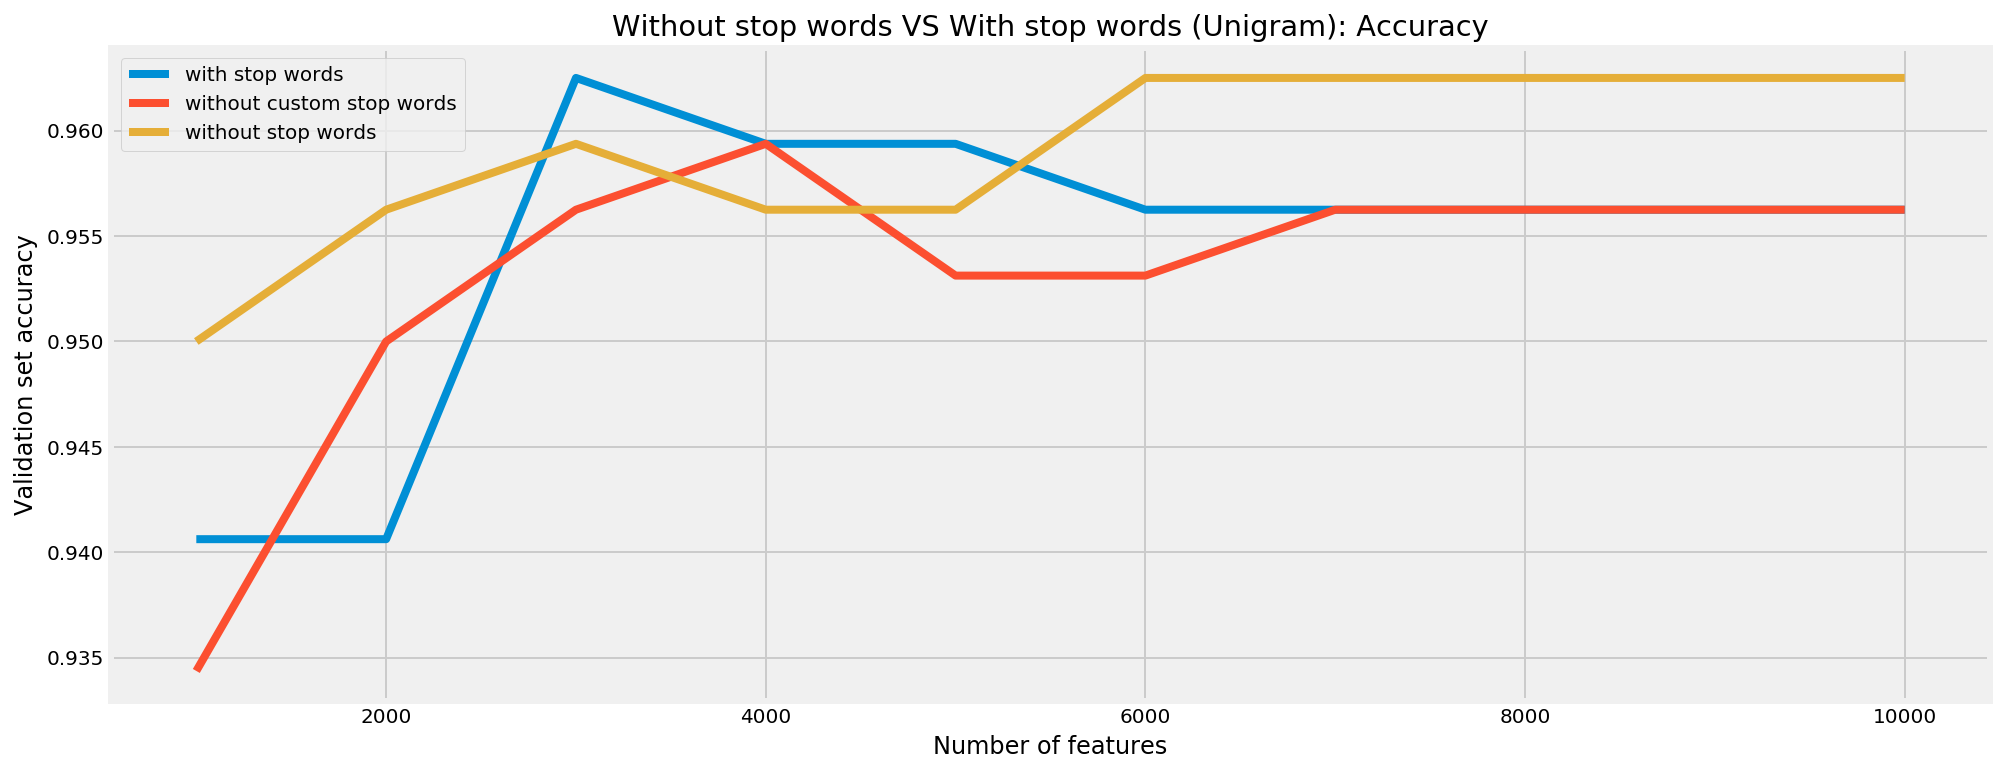

In [40]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(15,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

#### Accuracy is maximum after removing stop words

#### Checking accuracy for bigrams and after removing stop words

In [41]:
%%time
print ("RESULT FOR BIGRAM WITHOUT STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2), stop_words='english')

RESULT FOR BIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 1000 features
null accuracy: 92.81%
accuracy score: 94.38%
model is 1.56% more accurate than null accuracy
train and test time: 1.41s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 92.81%
accuracy score: 94.69%
model is 1.88% more accurate than null accuracy
train and test time: 1.45s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 92.81%
accuracy score: 95.94%
model is 3.12% more accurate than null accuracy
train and test time: 1.45s
-----------------------------------------------------------------

In [42]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3), stop_words='english')

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 1000 features
null accuracy: 92.81%
accuracy score: 94.69%
model is 1.88% more accurate than null accuracy
train and test time: 2.20s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 92.81%
accuracy score: 94.38%
model is 1.56% more accurate than null accuracy
train and test time: 1.97s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 92.81%
accuracy score: 96.25%
model is 3.44% more accurate than null accuracy
train and test time: 2.39s
-------------------------------------------------------------------

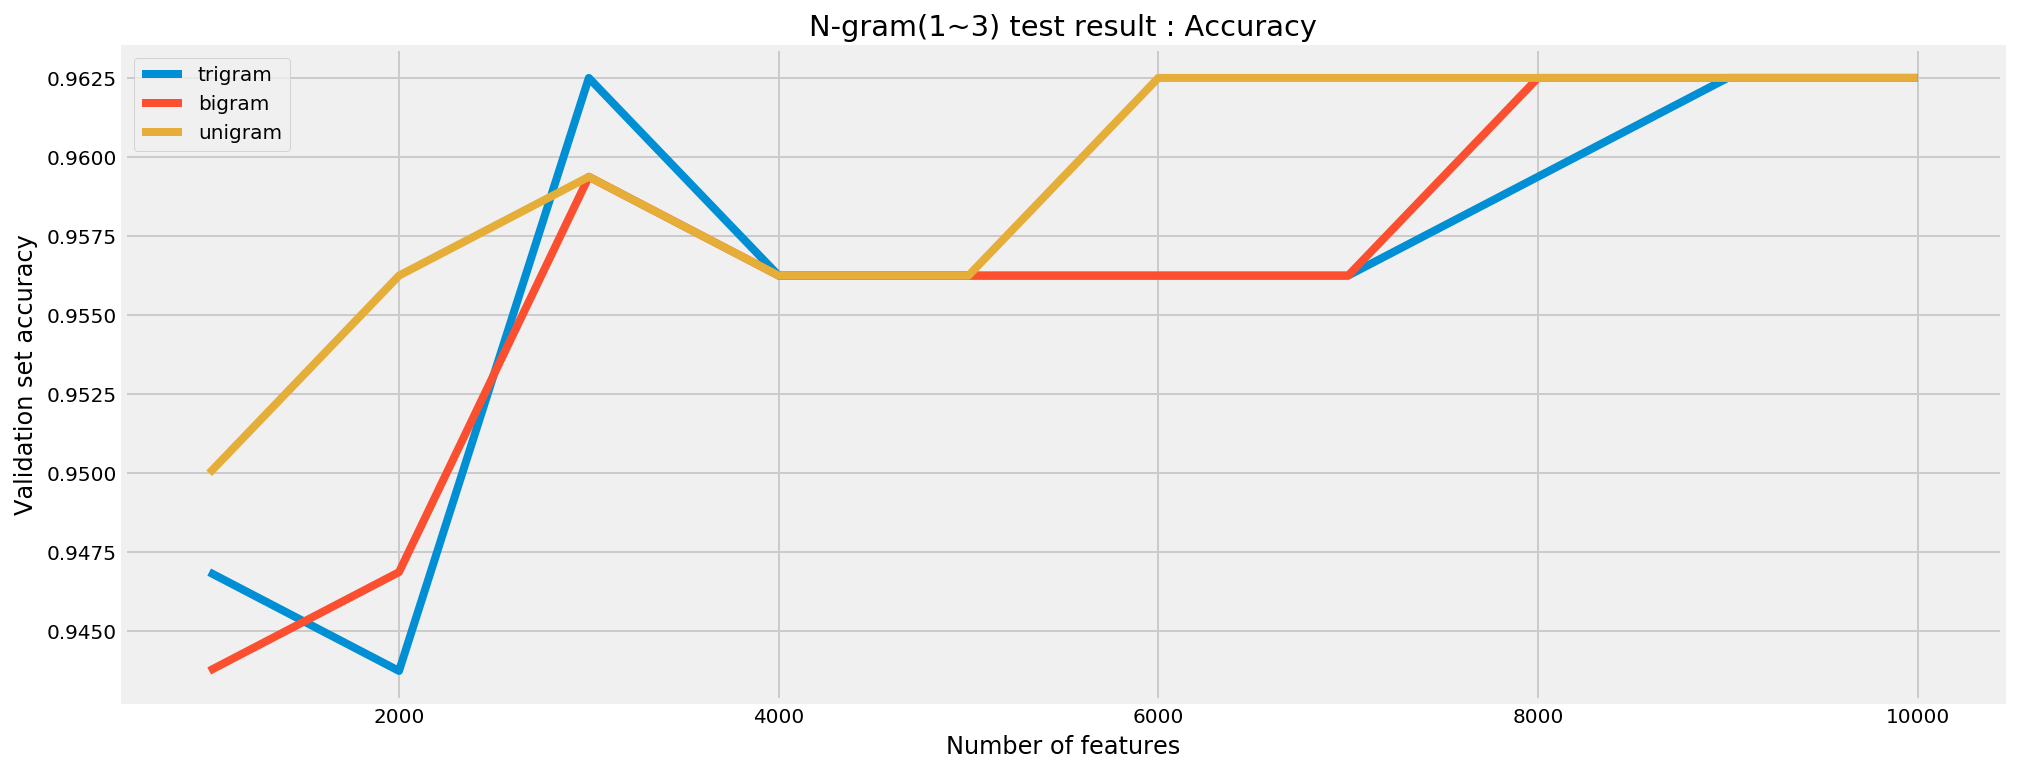

In [44]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(15,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

#### For unigram, best accuracy is with 6000 features
#### For bigrams, it is with 8000 features and with 9000 for trigram

#### Function to print accuracy for the model

In [46]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['normal', 'hate'],
                         columns=['predicted_normal','predicted_hate'])
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(y_test, y_pred, target_names=['normal','hate']))

In [50]:
%%time
ug_cvec = CountVectorizer(max_features=6000, stop_words='english')
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 92.81%
accuracy score: 96.25%
model is 3.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

        predicted_normal  predicted_hate
normal               294               3
hate                   9              14
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

     normal       0.97      0.99      0.98       297
       hate       0.82      0.61      0.70        23

avg / total       0.96      0.96      0.96       320

CPU times: user 748 ms, sys: 4 ms, total: 752 ms
Wall time: 620 ms


In [49]:
%%time
bg_cvec = CountVectorizer(max_features=8000,ngram_range=(1, 2), stop_words='english')
bg_pipeline = Pipeline([
        ('vectorizer', bg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 92.81%
accuracy score: 96.25%
model is 3.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

        predicted_normal  predicted_hate
normal               294               3
hate                   9              14
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

     normal       0.97      0.99      0.98       297
       hate       0.82      0.61      0.70        23

avg / total       0.96      0.96      0.96       320

CPU times: user 1.53 s, sys: 4 ms, total: 1.54 s
Wall time: 1.37 s


In [53]:
%%time
tg_cvec = CountVectorizer(max_features=9000,ngram_range=(1, 3), stop_words='english')
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 92.81%
accuracy score: 96.25%
model is 3.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

        predicted_normal  predicted_hate
normal               294               3
hate                   9              14
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

     normal       0.97      0.99      0.98       297
       hate       0.82      0.61      0.70        23

avg / total       0.96      0.96      0.96       320

CPU times: user 2.54 s, sys: 56 ms, total: 2.6 s
Wall time: 2.41 s


#### Make predictions

In [54]:
## Read test data
test = pd.read_csv('test_tweets_anuFYb8.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


#### Clean test tweets

In [55]:
%%time
print ("Cleaning test tweets...\n")
clean_test_tweets = []
for i in range(0,len(test)):
    if( (i+1)%5000 == 0):
        print("Tweets %d of %d has been processed" % ( i+1, len(test) ))
    clean_test_tweets.append(tweet_cleaner_updated(test['tweet'][i]))

Cleaning test tweets...

Tweets 5000 of 17197 has been processed
Tweets 10000 of 17197 has been processed
Tweets 15000 of 17197 has been processed
CPU times: user 5.57 s, sys: 128 ms, total: 5.7 s
Wall time: 5.72 s


In [56]:
clean_test_df = pd.DataFrame(clean_test_tweets,columns=['tweet'])
clean_test_df['id'] = test.id

In [58]:
id_val = clean_test_df.id
test_text = clean_test_df.tweet

#### Use bigram without stop words to make predictions

In [59]:
bg_fit = bg_pipeline.fit(x, y)
y_pred = bg_fit.predict(test_text)

#### Create a dataframe and then save predictions to csv

In [60]:
pred = pd.DataFrame(id_val, columns=['id'])
pred['label'] = y_pred

In [61]:
pred.to_csv('submission.csv')